# Keras of Load Data

In [7]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

同样的,由于我们的数据集过大无法一次性加入到内存,所以我们需要使用专门的方法去加载数据集.那么在Keras中我们可以使用```fit_generator```

```python

fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)
```

[1] ```generator```: 其是一个生成器,或者一个```keras.utils.Sequence```实例对象,输出应为下面两种形式:

-  一个```(inputs, targets)```元组

- 一个 ```(inputs, targets, sample_weights) ```元组.

[2] ```step_peer_epoch```: 在声明一个 epoch 完成并开始下一个 epoch 之前从 generator 产生的总步数（批次样本）. 它通常应该等于你的数据集的样本数量除以批量大小. 对于 Sequence,它是可选的:如果未指定,将使用len(generator) 作为步数.也就是说,一般情况下我们的generator是死循环:

```python
def generate_arrays_from_file(path):
    while True:
        with open(path) as f:
            for line in f:
            # 从文件中的每一行生成输入数据和标签的 numpy 数组，
            x1, x2, y = process_line(line)
            yield ({'input_1': x1, 'input_2': x2}, {'output': y})
        f.close()```

可以看到官方案例中给出的genreate是一个死循环,那么即可以无限的yield出结果,所以我们就需要定义一个epoch的数量是多少,在一般情况下等于数据集的样本数量除以批量大小.

[3] ```validation_data```: 验证数据的生成器或 Sequence 实例

- 一个 (inputs, targets) 元组.

- 一个 (inputs, targets, sample_weights) 元组.

[3] ```validation_steps```:仅当 validation_data 是一个生成器时才可用.在停止前 generator 生成的总步数(样本批数) 对于 Sequence,它是可选的:如果未指定,将使用 len(generator) 作为步数.由于我们的验证集样本也是比较大的,所以我们也需要将```validation_data```设置为一个generate的形式.

更多情况查看[fit_generator](https://keras.io/zh/models/model/#fit_generator).

### 1. Split data set

首先,我们需要将数据集```CatsVsDogs```拆分为train/test data.

SplitData类接受4个参数:

1.file_dir:文件路径.

2.Load_samples: 加载的样本量大小,如果为```None```则全部加载.

3.Shuffle: 是否打乱数据,建议打乱.

4.test_rate: 测试样本率.

返回4个值:

1.train_files: 含有训练样本的路径.

2.test_files: 含有测试样本的路径.

3.train_samples: 训练样本总数.

4.test_samples: 测试样本总数.

In [1]:
class SplitData:

    def __init__(self, file_dir, Load_samples=None, Shuffle=True, test_rate=0.3):
        """
        Argus:
        -----
            file_dir (string): data set file path like "../train/"
            Load_samples (Int): Load_samples (Int): Load data number. if given None, load all samples.
            Shuffle (bool): is shuffle data set. Suggest True. default true.
            test_rate (float): split test data rate. default 0.3.
        """
        self.file_dir = file_dir
        self.test_rate = test_rate
        self.Load_samples = Load_samples
        self.Shuffle = Shuffle

    def __call__(self):

        # loading all path in current file dir.
        files_list = os.listdir(self.file_dir)

        if self.Shuffle:
            np.random.shuffle(files_list)

        if self.Load_samples:
            files_list = files_list[:self.Load_samples]

        # split data
        len_ = len(files_list)
        test_index = int(np.floor(len_ * self.test_rate))
        test_files = files_list[:test_index]
        train_files = files_list[test_index:]

        # join path
        test_files = [os.path.join(self.file_dir, file) for file in test_files]
        train_files = [os.path.join(self.file_dir, file) for file in train_files]

        train_samples, test_samples = len_ - test_index, test_index

        return train_files, test_files, train_samples, test_samples

这里我们尝试加载10个样本,测试样本率0.3.

In [4]:
file_dir = '/Users/huwang/Joker/Data_Set/catVSdot/train'
split_data = SplitData(file_dir, Load_samples=10, test_rate=0.3)
train_files, test_files, train_samples, test_samples = split_data()

print('Train Samples is {}, Test Samples is {}'.format(train_samples,test_samples))
print('First train file path: {}'.format(train_files[0]))

Train Samples is 7, Test Samples is 3
First train file path: /Users/huwang/Joker/Data_Set/catVSdot/train/cat.7369.jpg


这样我们就能够划分出训练样本和测试样本,接下去我们需要将其传递到Generate中进行处理.

### 2. Generate

现在我们先来创建```fit_generator```,需要注意的是,在官方案例```generate_arrays_from_file```并没有实现batch,所以我们需要手动实现batch,在实现含有batch的generate时我们需要注意一点:

**如果给予的batch size大于样本总数,那么我们需要将整除结果设置为1.**

In [24]:
def generate_train(data, batch_size):
    """
    Argus:
    ------
    data (list): include training data set files path.
    batch_size (Int): batch size loaded.

    Return:
    -------
        yield (X, y), it's a generate.
    """
    m = len(data)
    N = m // batch_size
    N = np.maximum(N, 1)

    np.random.shuffle(data)

    while True:

        for n in range(N):
            X = []
            y = []
            bs_data = data[n * batch_size:(n + 1) * batch_size]

            for file in bs_data:

                classes = file.split('/')[-1].split('.', 1)[0]
                if classes == 'cat':
                    label = 0
                else:
                    label = 1
                # handle images.
                image = Image.open(file)
                image = image.resize((224, 224))
                image = np.array(image)
                image = np.divide(image, 255)

                X.append(image)
                y.append(label)

            else:
                X = np.array(X)
                X = np.pad(X, pad_width=((0, 0), (1, 2), (1, 2), (0, 0)), mode='constant')
                y = np.array(y)
                yield (X, y)

```generate_train```函数接受两个参数:

1.data: 由```SplitData```划分出来的列表.

2.batch size: 一次迭代生成多少的样本.

在使用batch size的时候,如果我们的batch size 大于 样本总数,比如在```SplitData```中设置```Load_samples=10```,且在```generate_train```中设置```batch size=64```,那么代码中的```N=0```,for循环无法执行,所以**如果给予的batch size大于样本总数,那么我们需要将整除结果设置为1**

接着我们处理一下图片包括label的设置:cat为0,dog为1.以及图片的resize到$(224,224)$和归一化图片.

最后我们将其pad到$(227,227)$.

现在我们来尝试```generate_train```,现在测试batch size < m sample

The generate result X shape:(2, 227, 227, 3)


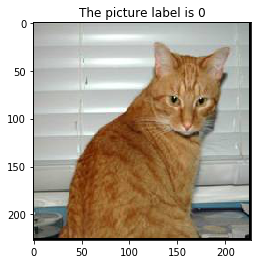

In [25]:
generate = generate_train(train_files, 2)
X,y = next(generate)

print('The generate result X shape:{}'.format(X.shape))
plt.imshow(X[0])
plt.title('The picture label is {}'.format(y[0]))
plt.show()

现在我们测试batch size > m sampl.

The generate result X shape:(7, 227, 227, 3)


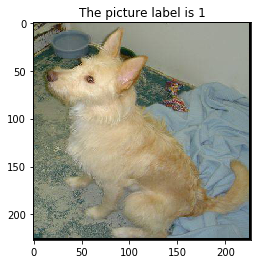

In [26]:
generate = generate_train(train_files, 10)
X,y = next(generate)

print('The generate result X shape:{}'.format(X.shape))
plt.imshow(X[0])
plt.title('The picture label is {}'.format(y[0]))
plt.show()

这样我们就可以保证无论何种情况我们能够有效的取出样本进行训练.同样的,我们设置```generate_test```,来保证测试样本的迭代.

详情查看[LoadDataset](LoadDataset.py)

### 3. Crop


我们知道AlexNet模型在测试阶段,输入一张$(256\times 256)$的图片,截取四个角以及中心后得到5张图片并将其水平翻转得到10张图片,最后取概率最大类.

那么我们可以直接使用Pytorch中[transforms.FiveCrop](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.FiveCrop)可以直接获取四个角以及中心5张图片,其返回一个tuple,并且tuple中是PIL对象,这意味着我们可以使用PIL中的方法.

#### 3.1  FiveCrop

In [43]:
file_path = 'dog.jpg'
five_crop = transforms.FiveCrop((224,224))

image = Image.open(file_path)
image = image.resize((256,256))

Five_image = five_crop(image) # return PIL type

print('The FiveCrop Result:\n',Five_image)

The FiveCrop Result:
 (<PIL.Image.Image image mode=RGB size=224x224 at 0x11E162B38>, <PIL.Image.Image image mode=RGB size=224x224 at 0x10EEB1358>, <PIL.Image.Image image mode=RGB size=224x224 at 0x11EFF2BE0>, <PIL.Image.Image image mode=RGB size=224x224 at 0x124DD3C88>, <PIL.Image.Image image mode=RGB size=224x224 at 0x124DD3FD0>)


我们可以随意查看其中一张,比如左上角.

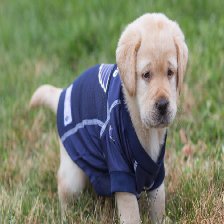

In [44]:
Five_image[0]

由于tuple中的对象是PIL,那么我们就可以使用```img.transpose(Image.FLIP_LEFT_RIGHT)```来将其水平翻转,最后统一转换成ndarray拼接到一个$(10\times 224\times 224\times 3)$的ndarray.

In [45]:
class Crop:

    def __init__(self, file_path):
        """
        Argus:
        -----
            file_path (string):   include testing data set files path.
        """
        self.file_path = file_path

    def __call__(self):
        image = Image.open(self.file_path)
        image = image.resize((256, 256))
        # get five pictures.
        five = transforms.FiveCrop(size=(224, 224))
        five_img = five(image)
        # transpose image of left and right.
        five_img_transpose = [np.array(img.transpose(Image.FLIP_LEFT_RIGHT)) for img in five_img]
        five_img = [np.array(img) for img in five_img]

        # stack two array. result shape (10,...)
        Img = np.vstack((five_img_transpose, five_img)) 
        Img = np.pad(Img, pad_width=((0, 0), (1, 2), (1, 2), (0, 0)), mode='constant')
        return Img

类```Crop```接受一个参数:```file_path```即测试样本的路径.

使用```Image```打开样本,并resize到$(256,256)$,使用```FiveCrop```提取5张图片,将其水平翻转后拼接数组得到$(10\times 224\times 224\times 3)$的ndarray.

接下来我们来查看是否按照我们的要求生成测试样本.

为了测试方便,我们将```np.pad```先注释,但是在训练的过程中我们会打开,因为我们的模型接受的是$(227,227,3)$的结构.

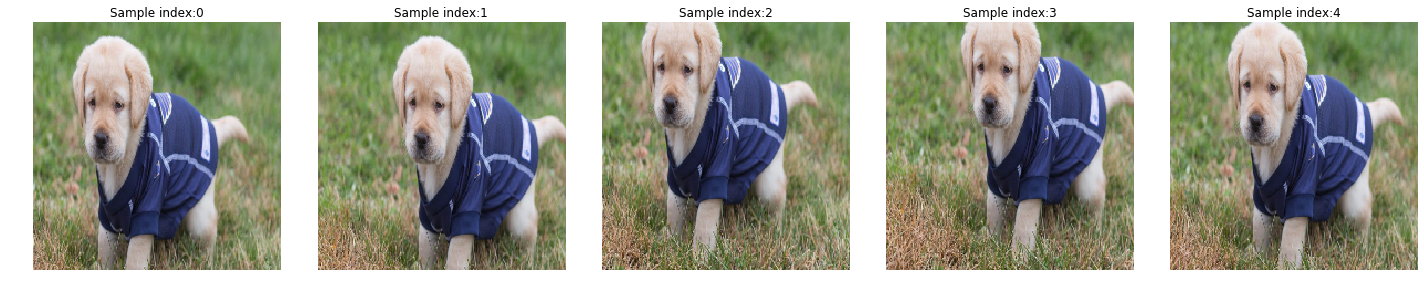

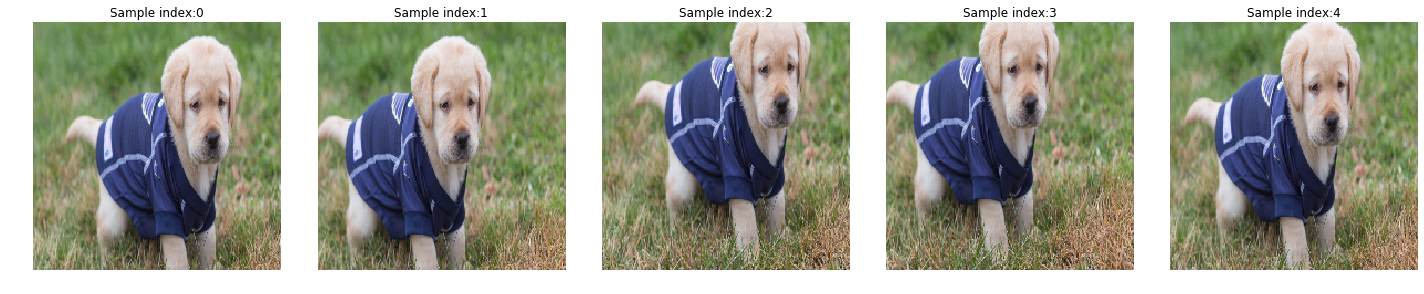

In [56]:
file_path = 'dog.jpg'
corp = Crop(file_path)
fig = plt.figure(figsize=(20,30))
images = corp()


for i in range(5):
    image = images[i]
    ax = plt.subplot(1,5,i+1)
    plt.tight_layout()
    ax.set_title('Sample index:{}'.format(i))
    ax.axis('off') # trun of axis
    plt.imshow(image)

fig = plt.figure(figsize=(20,30))
for i in range(5):
    image = images[i+5]
    ax = plt.subplot(1,5,i+1)
    plt.tight_layout()
    ax.set_title('Sample index:{}'.format(i))
    ax.axis('off') # trun of axis
    plt.imshow(image)
    
plt.show()
    

到此,我们就完成了所有的样本加载步骤.

接下去让我们看看如何使用Keras搭建AlexNet.